In [ ]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import shap

In [ ]:
#Load dataset
df=pd.read_excel("/content/time_series_dataset.xlsx")


In [ ]:
df.head()

,date,temperature,humidity,wind_speed,pressure,energy_consumption
0,2020-01-01,32.483571,51.710050,11.513977,1011.843367,14.795992
1,2020-01-02,29.308678,54.398190,8.155669,1008.033306,7.262875
2,2020-01-03,33.238443,67.472936,11.739212,1010.143724,10.708990
3,2020-01-04,37.615149,66.103703,12.711276,1016.392259,15.316591
4,2020-01-05,28.829233,59.790984,10.826870,1010.955495,9.567285


In [ ]:
#convert Date column
df['date']=pd.to_datetime(df['date'])



In [ ]:
df

,date,temperature,humidity,wind_speed,pressure,energy_consumption
0,2020-01-01,32.483571,51.710050,11.513977,1011.843367,14.795992
1,2020-01-02,29.308678,54.398190,8.155669,1008.033306,7.262875
2,2020-01-03,33.238443,67.472936,11.739212,1010.143724,10.708990
3,2020-01-04,37.615149,66.103703,12.711276,1016.392259,15.316591
4,2020-01-05,28.829233,59.790984,10.826870,1010.955495,9.567285
...,...,...,...,...,...,...
295,2020-10-22,26.535452,54.899836,11.297420,1012.202374,14.366865
296,2020-10-23,34.497999,57.301251,9.665764,1009.901811,15.780548
297,2020-10-24,31.536498,50.212363,10.293427,1012.762450,15.473385
298,2020-10-25,34.064311,55.557067,12.413018,1011.119571,17.308782


In [ ]:
#sorting by date
df=df.sort_values('date')

In [ ]:
df

,date,temperature,humidity,wind_speed,pressure,energy_consumption
0,2020-01-01,32.483571,51.710050,11.513977,1011.843367,14.795992
1,2020-01-02,29.308678,54.398190,8.155669,1008.033306,7.262875
2,2020-01-03,33.238443,67.472936,11.739212,1010.143724,10.708990
3,2020-01-04,37.615149,66.103703,12.711276,1016.392259,15.316591
4,2020-01-05,28.829233,59.790984,10.826870,1010.955495,9.567285
...,...,...,...,...,...,...
295,2020-10-22,26.535452,54.899836,11.297420,1012.202374,14.366865
296,2020-10-23,34.497999,57.301251,9.665764,1009.901811,15.780548
297,2020-10-24,31.536498,50.212363,10.293427,1012.762450,15.473385
298,2020-10-25,34.064311,55.557067,12.413018,1011.119571,17.308782


In [ ]:
#checking missing values

df.isnull().sum()

,0
date,0
temperature,0
humidity,0
wind_speed,0
pressure,0
energy_consumption,0


In [ ]:
#Feature Engineering
df['day']=df['date'].dt.day
df['month']=df['date'].dt.month
df['year']=df['date'].dt.year
df['lag1']=df['energy_consumption'].shift(1)
df['rolling3']=df['energy_consumption'].rolling(3).mean()
df=df.dropna()

In [ ]:
#select features
features=['temperature','humidity','wind_speed','pressure','day','month','lag1','rolling3','energy_consumption']
data=df[features]

In [ ]:
#scaling
scaler=MinMaxScaler()
scaled=scaler.fit_transform(data)

In [ ]:
#sequence creation
def create_sequences(data,window=7,target_index=8):
  x, y = [], []
  for i in range(len(data) - window):
    x.append(data[i:i+window])
    y.append(data[i+window,target_index])
  return np.array(x), np.array(y)

window=7
x, y = create_sequences(scaled,window)

In [ ]:
#train-test split
train_size = int(len(x) * 0.80)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
#LSTM Model
model=Sequential([LSTM(64,return_sequences=True,input_shape=(x_train.shape[1],x_train.shape[2])),LSTM(32),Dense(1)])
model.compile(optimizer='adam',loss='mse')
model.fit(x_train,y_train,epochs=20,batch_size=32,validation_split=0.1,verbose=1)
y_pred=model.predict(x_test)

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.1345 - val_loss: 0.0558
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0531 - val_loss: 0.0360
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0300 - val_loss: 0.0415
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0344 - val_loss: 0.0350
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0313 - val_loss: 0.0365
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0333 - val_loss: 0.0359
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0342 - val_loss: 0.0358
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0316 - val_loss: 0.0351
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0330 - val_loss: 0.0351
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0336 - val_loss: 0.0359
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0325 - val_loss: 0.0350
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0306 - val_loss: 0.0353
Epoch 13/20


In [ ]:
#evaluation
rmse=np.sqrt(mean_squared_error(y_test,y_pred))
mae=mean_absolute_error(y_test,y_pred)
print("Rmse:",rmse)
print('MAE:',mae)

Rmse: 0.19232260109647104
MAE: 0.15485863477009057


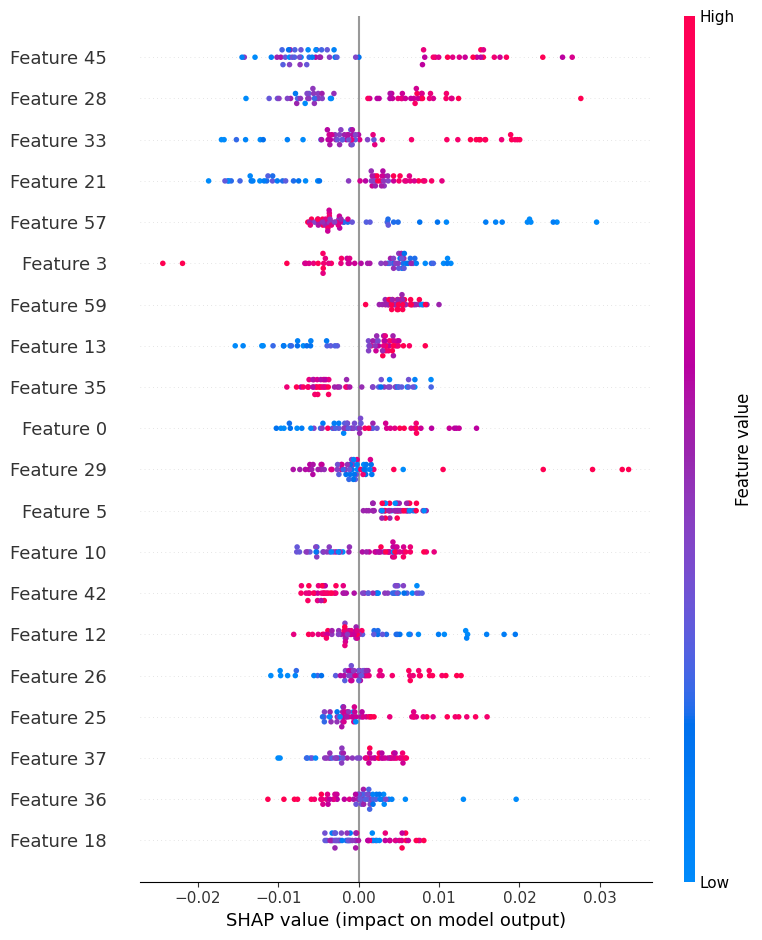

In [ ]:
#SHAP Explainability using surrogate model
x_train_flat=x_train.reshape(x_train.shape[0],-1)
x_test_flat=x_test.reshape(x_test.shape[0],-1)
surrogate=RandomForestRegressor()
surrogate.fit(x_train_flat,y_train)
explainer=shap.TreeExplainer(surrogate)
shap_values=explainer.shap_values(x_test_flat)
shap.summary_plot(shap_values,x_test_flat)